In [1]:
import sys
sys.path.append('../')

import os

import cqt
import cqt.env.mkt_env as env 
import cqt.env.mkt_env_spot as envspot
import cqt.ledger.ledger as ledger
import cqt.datagen as dg
import cqt.dbutility.dbutility as db
import cqt.strats.strategy as stg
import cqt.strats.strategy_long_short_average as stg_ls
import pandas as pd
import pickle

from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.collections as collections
from talib.abstract import *
import copy

In [73]:
data = pd.read_csv('../data/webdata/Gemini_BTCUSD_d_20191117.csv',skiprows=1)
data.rename(columns={'Open': 'price_open', 'High': 'price_high', 'Low': 'price_low', 'Close': 'price_close', 'Volume BTC':'volume_traded','Date':'time_close'},inplace=True)
df_btc=dg.IndexedData("","",data)

config = {'asset_type': 'spot'}
model_btc = env.MktEnv([])
comp_btc = envspot.MktEnvSpot('btc', df_btc, config)
comp_btc.data=comp_btc.data.sort_index()
model_btc.insert_section(comp_btc)


In [74]:
prices = copy.deepcopy(comp_btc.data)
prices.rename(columns={'price_open': 'open', 'price_high': 'high', 'price_low': 'low', 'price_close': 'close', 'volume_traded': 'volume'}, inplace=True)
close = pd.Series(prices['close'].values)
sma15 = SMA(prices, timeperiod=15)
sma60 = SMA(prices, timeperiod=60)
rsi = RSI(prices, timeperiod=14)
atr = ATR(prices, timeperiod=7)

In [77]:
prices['diff1']=prices.close.diff(1)

In [79]:
prices['diff3']=prices.close.diff(3)
prices['diff7']=prices.close.diff(7)
prices['diff10']=prices.close.diff(10)

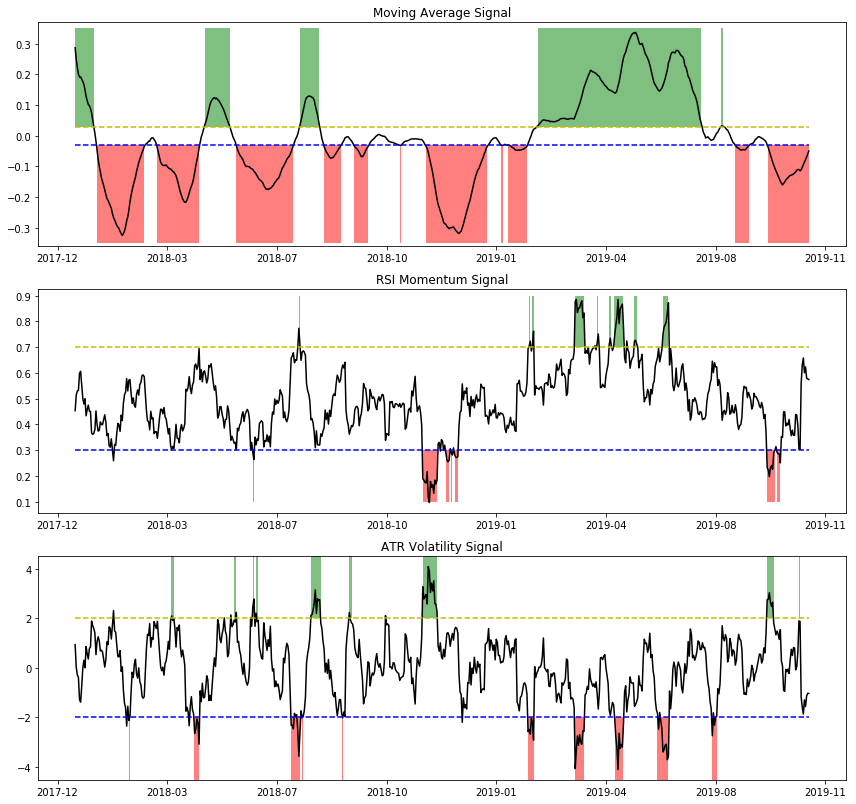

In [19]:
fig_width = 12
fig_height = 12
fig, ax = plt.subplots(3,1, figsize=(fig_width,fig_height))
start=816
end=1486
t=range(start,end)
signal_ma=sma15[start:end]/sma60[start:end]-1
ax[0].set_title('Moving Average Signal')
ax[0].plot(t,signal_ma,'black',t,[0.03]*(end-start),'y--',t,[-0.03]*(end-start),'b--')
collection = collections.BrokenBarHCollection.span_where(t
    , ymin=0.03, ymax=.35, where=signal_ma > 0.03, facecolor='green', alpha=0.5)
ax[0].add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=-.35, ymax=-0.03, where=signal_ma < -0.03, facecolor='red', alpha=0.5)
ax[0].add_collection(collection)
ax[0].set_xticklabels(newlabels)
signal_rsi=rsi[start:end]/100
ax[1].set_title('RSI Momentum Signal')
ax[1].plot(t,signal_rsi,'black',t,[0.7]*(end-start),'y--',t,[0.3]*(end-start),'b--')
collection = collections.BrokenBarHCollection.span_where(t
    , ymin=0.7, ymax=0.9, where=signal_rsi > 0.7, facecolor='green', alpha=0.5)
ax[1].add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0.1, ymax=0.3, where=signal_rsi < 0.3, facecolor='red', alpha=0.5)
ax[1].add_collection(collection)
ax[1].set_xticklabels(newlabels)
signal_atr=(-close[start:end]+sma15[start:end])/atr[start:end]
ax[2].set_title('ATR Volatility Signal')
ax[2].plot(t,signal_atr,'black',t,[2]*(end-start),'y--',t,[-2]*(end-start),'b--')
collection = collections.BrokenBarHCollection.span_where(t
    , ymin=2, ymax=6, where=signal_atr > 1.8, facecolor='green', alpha=0.5)
ax[2].add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=-6, ymax=-2, where=signal_atr < -1.8, facecolor='red', alpha=0.5)
ax[2].add_collection(collection)
ax[2].set_xticklabels(newlabels)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

In [ ]:
labels = [item.get_text() for item in ax[1].get_xticklabels()]
labels

In [13]:
newlabels=['',prices.index[800].strftime('%Y-%m'),prices.index[900].strftime('%Y-%m'),prices.index[1000].strftime('%Y-%m'),prices.index[1100].strftime('%Y-%m'),prices.index[1200].strftime('%Y-%m'),
          prices.index[1300].strftime('%Y-%m'),prices.index[1400].strftime('%Y-%m'),'2019-11','']

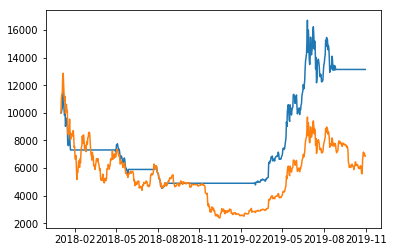

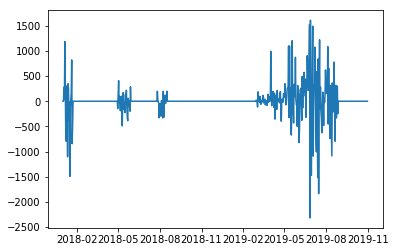

In [47]:
#test strategy
cash = 10000
assets = {'btc': 0}
ini_pfo = ledger.Ledger(assets, cash)
#moving average strategy
ls_rule = {'method' : 'moving_average', 'window_size' : [15, 60], 'tolerance_up' : 0.03, 'tolerance_down' : 0.03}
strats_ma = stg_ls.StrategyInverseMA(model_btc, ini_pfo, ls_rule)
start_date_str = '2018-01-01'
end_date_str='2019-11-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
end_date=datetime.strptime(end_date_str, '%Y-%m-%d')
report_ma = strats_ma.back_testing(start_date ,end_date)
report_ma['ma_signal']=strats_ma.signal[817:]

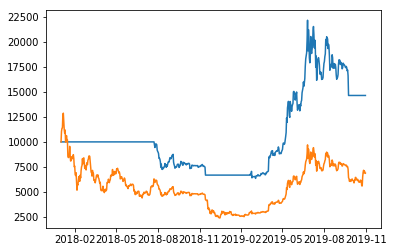

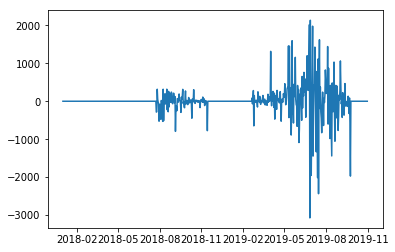

In [48]:
import cqt.strats.StrategyRSI as stg_rsi

# RSI Strategy
rsi_rule = {'method' : 'RSI'}
strats_rsi = stg_rsi.StrategyRSI(model_btc, ini_pfo, rsi_rule)
start_date_str = '2018-01-01'
end_date_str='2019-11-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
end_date=datetime.strptime(end_date_str, '%Y-%m-%d')
report_rsi = strats_rsi.back_testing(start_date ,end_date)
report_rsi['signal']=strats_rsi.signal[817:]

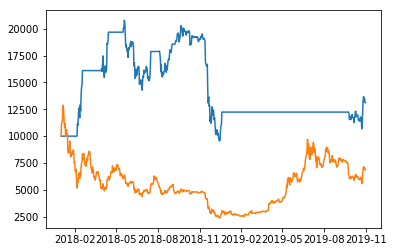

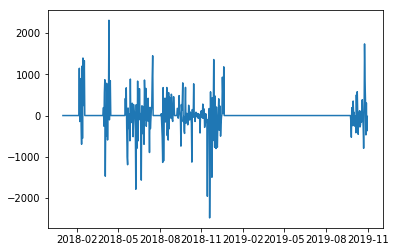

In [49]:
import cqt.strats.StrategyATR as stg_atr

# ATR Strategy
atr_rule = {'method' : 'ATR','bandwidth':[-2,2],'timeperiod':[15,7]}
strats = stg_atr.StrategyATR(model_btc, ini_pfo, atr_rule)
start_date_str = '2018-01-01'
end_date_str='2019-11-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
end_date=datetime.strptime(end_date_str, '%Y-%m-%d')
report_atr = strats.back_testing(start_date ,end_date)
report_atr['signal']=strats.signal[817:]

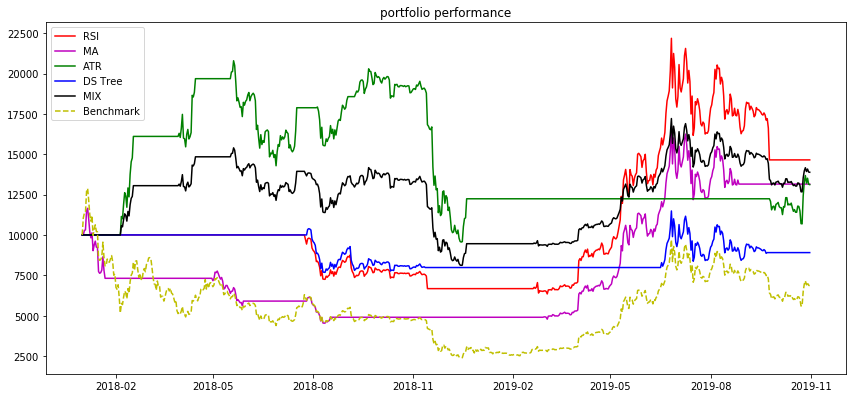

In [229]:
fig_width = 12
fig_height = 6
fig, ax = plt.subplots(figsize=(fig_width,fig_height))
t=report_rsi['date']
ax.plot(t, report_rsi['total'],'r',label='RSI')
ax.plot(t, report_ma['total'],'m',label='MA')
ax.plot(t, report_atr['total'],'g',label='ATR')
ax.plot(t, df['total'],'b',label='DS Tree')
ax.plot(t, (report_atr['total']+report_rsi['total'])*0.5,'black',label='MIX')
ax.plot(t, report_atr['btc_price'] * cash / report_atr['btc_price'][0],'y--',label='Benchmark')
ax.set_title('portfolio performance')#fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.legend()
plt.show()

In [54]:
import collections
df=pd.DataFrame(collections.OrderedDict({'date':report_atr.date,'btc_price':report_atr.btc_price,'ma_signal':report_ma.ma_signal,
                 'rsi_signal':report_rsi.signal,'atr_signal':report_atr.signal}))


In [97]:
df['diff1']=prices.diff1.values[817:1486]

In [103]:
df['diff3']=prices.diff3.values[819:1488]

In [106]:
df['diff7']=prices.diff7.values[823:1492]
df['diff10']=prices.diff10.values[826:1495]

In [121]:
df.diff1=df.diff1/df.btc_price

In [123]:
df.diff3=df.diff3/df.btc_price
df.diff10=df.diff10/df.btc_price
df.diff7=df.diff7/df.btc_price

In [165]:
df['bull']=df.apply(lambda row: all([row['diff1']>0.005,row['diff3']>0.01,row['diff7']>0.03,row['diff10']>0.03]), axis=1)

In [166]:
df['bear']=df.apply(lambda row: all([row['diff1']<-0.005,row['diff3']<-0.01,row['diff7']<-0.03,row['diff10']<-0.03]), axis=1)

In [168]:
df['target']=df.apply(lambda row:1 if row['bull'] else -1 if row['bear'] else 0,axis=1)

In [146]:
from sklearn import tree

In [152]:
df['bear']=df.apply(lambda row:-1 if row['bear'] else 0,axis=1)

In [185]:
bull_tree=tree.DecisionTreeClassifier()
bull_tree=bull_tree.fit(df[['ma_signal','rsi_signal','atr_signal']],df.target)

[Text(128.175,205.737,'X[0] <= -0.5\ngini = 0.426\nsamples = 669\nvalue = [94, 491, 84]'),
 Text(54.688,168.33,'X[2] <= -0.5\ngini = 0.505\nsamples = 213\nvalue = [37, 141, 35]'),
 Text(27.344,130.923,'X[1] <= 0.5\ngini = 0.477\nsamples = 28\nvalue = [0, 17, 11]'),
 Text(13.672,93.5167,'gini = 0.375\nsamples = 4\nvalue = [0, 1, 3]'),
 Text(41.016,93.5167,'gini = 0.444\nsamples = 24\nvalue = [0, 16, 8]'),
 Text(82.032,130.923,'X[2] <= 0.5\ngini = 0.494\nsamples = 185\nvalue = [37, 124, 24]'),
 Text(68.36,93.5167,'X[1] <= 0.5\ngini = 0.487\nsamples = 174\nvalue = [32, 118, 24]'),
 Text(54.688,56.11,'gini = 0.483\nsamples = 163\nvalue = [31, 111, 21]'),
 Text(82.032,56.11,'gini = 0.512\nsamples = 11\nvalue = [1, 7, 3]'),
 Text(95.704,93.5167,'gini = 0.496\nsamples = 11\nvalue = [5, 6, 0]'),
 Text(201.662,168.33,'X[1] <= -0.5\ngini = 0.384\nsamples = 456\nvalue = [57, 350, 49]'),
 Text(136.72,130.923,'X[0] <= 0.5\ngini = 0.393\nsamples = 41\nvalue = [11, 30, 0]'),
 Text(123.048,93.5167,'gi

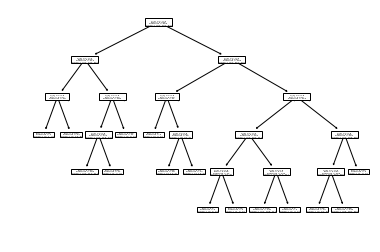

In [170]:
tree.plot_tree(bull_tree)

In [171]:
from sklearn.tree.export import export_text
r = export_text(bull_tree)
print(r)

|--- feature_0 <= -0.50
|   |--- feature_2 <= -0.50
|   |   |--- feature_1 <= 0.50
|   |   |   |--- class: 1
|   |   |--- feature_1 >  0.50
|   |   |   |--- class: 0
|   |--- feature_2 >  -0.50
|   |   |--- feature_2 <= 0.50
|   |   |   |--- feature_1 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_1 >  0.50
|   |   |   |   |--- class: 0
|   |   |--- feature_2 >  0.50
|   |   |   |--- class: 0
|--- feature_0 >  -0.50
|   |--- feature_1 <= -0.50
|   |   |--- feature_0 <= 0.50
|   |   |   |--- class: -1
|   |   |--- feature_0 >  0.50
|   |   |   |--- feature_2 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_2 >  0.50
|   |   |   |   |--- class: 0
|   |--- feature_1 >  -0.50
|   |   |--- feature_0 <= 0.50
|   |   |   |--- feature_2 <= -0.50
|   |   |   |   |--- feature_1 <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_1 >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_2 >  -0.50
|   |   |   |   |--- feature_2 <= 0.50
|

In [187]:
df['ds_predict']=bull_tree.predict(df[['ma_signal','rsi_signal','atr_signal']])

In [191]:
df[df.ds_predict!=0]

,date,btc_price,ma_signal,rsi_signal,atr_signal,diff1,diff3,diff7,diff10,bull,bear,target,ds_predict
206,2018-07-26,7926.36,-1.0,0.0,-1.0,0.033540,0.036549,-0.049248,-0.112826,False,False,0,1
316,2018-11-13,6258.26,0.0,-1.0,1.0,-0.104163,-0.118642,-0.304085,-0.314786,False,True,-1,-1
317,2018-11-14,5606.38,0.0,-1.0,1.0,-0.006006,-0.018326,-0.189019,-0.323986,False,True,-1,-1
318,2018-11-15,5572.71,0.0,-1.0,1.0,-0.010218,-0.002205,-0.234970,-0.294137,False,False,0,-1
319,2018-11-16,5515.77,0.0,-1.0,1.0,-0.002199,-0.141766,-0.222547,-0.323677,False,False,0,-1
531,2019-06-16,8989.89,-1.0,0.0,-1.0,0.037947,0.032565,0.206113,0.439000,True,False,1,1
533,2019-06-18,9084.31,-1.0,0.0,-1.0,0.021833,0.126549,0.294529,0.363696,True,False,1,1
534,2019-06-19,9282.65,-1.0,0.0,-1.0,0.027172,0.150154,0.393616,0.280447,True,False,1,1
630,2019-09-23,9693.28,0.0,-1.0,1.0,-0.118631,-0.167970,-0.143555,-0.153388,False,True,-1,-1
631,2019-09-24,8543.36,0.0,-1.0,1.0,-0.013046,-0.040541,-0.024901,-0.045188,False,False,0,-1


In [222]:
df['total']=df.btc_price*0
df['cash']=df.btc_price*0
df['btc_holding']=df.btc_price*0

In [223]:
df.at[0,'cash']=10000
df.at[0,'total']=10000

In [224]:
for i in range(1,df.shape[0]):
    if df.at[i,'ds_predict']==1:
        if df.at[i-1,'btc_holding']==0:
            df.at[i,'total']=df.at[i-1,'cash']
            df.at[i,'cash']=0
            df.at[i,'btc_holding']=df.at[i,'total']/df.at[i,'btc_price']
        else:
            df.at[i,'btc_holding']=df.at[i-1,'btc_holding']
            df.at[i,'cash']=0
            df.at[i,'total']=df.at[i,'btc_holding']*df.at[i,'btc_price']
            
    elif df.at[i,'ds_predict']==-1: 
        if df.at[i-1,'btc_holding']==0:
            df.at[i,'total']=df.at[i-1,'total']
            df.at[i,'cash']=df.at[i-1,'cash']
            df.at[i,'btc_holding']=0
        else:
            df.at[i,'total']=df.at[i-1,'total']
            df.at[i,'cash']=df.at[i,'total']
            df.at[i,'btc_holding']=0
    else:
        if df.at[i-1,'btc_holding']==0:
            df.at[i,'total']=df.at[i-1,'total']
            df.at[i,'cash']=df.at[i-1,'cash']
            df.at[i,'btc_holding']=0
        else:
            df.at[i,'btc_holding']=df.at[i-1,'btc_holding']
            df.at[i,'cash']=0
            df.at[i,'total']=df.at[i,'btc_holding']*df.at[i,'btc_price']